# Import Library

In [112]:
!pip install keras_tuner

In [113]:
import os
import shutil
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import drive

# Library Statistik untuk EDA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [114]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
# Load Data
transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))

## Merging Data

In [116]:
# Merging
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [117]:
# Filter Store ID 4 (Pusat Elektronik Sakti)
TARGET_STORE_ID = 4
df_electronic = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_electronic['transactionDate'] = pd.to_datetime(df_electronic['transactionDate'])

## Data Cleaning

In [118]:
# Agregasi Harian
time_series_electronic = df_electronic.groupby(df_electronic['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_electronic.columns = ['date', 'revenue']
time_series_electronic['date'] = pd.to_datetime(time_series_electronic['date'])
time_series_electronic.set_index('date', inplace=True)

In [119]:
# Reindex agar tanggal berurutan
all_days = pd.date_range(start=time_series_electronic.index.min(), end=time_series_electronic.index.max(), freq='D')
time_series_electronic = time_series_electronic.reindex(all_days, fill_value=0)

In [120]:
# Handling Outliers (Clipping)
Q1 = time_series_electronic['revenue'].quantile(0.25)
Q3 = time_series_electronic['revenue'].quantile(0.75)
IQR = Q3 - Q1
time_series_electronic['revenue_clean'] = time_series_electronic['revenue'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print(f"Data Elektronik (Store {TARGET_STORE_ID}) berhasil dibersihkan.")

Data Elektronik (Store 4) berhasil dibersihkan.


# Exploratory Data Analysis (EDA)

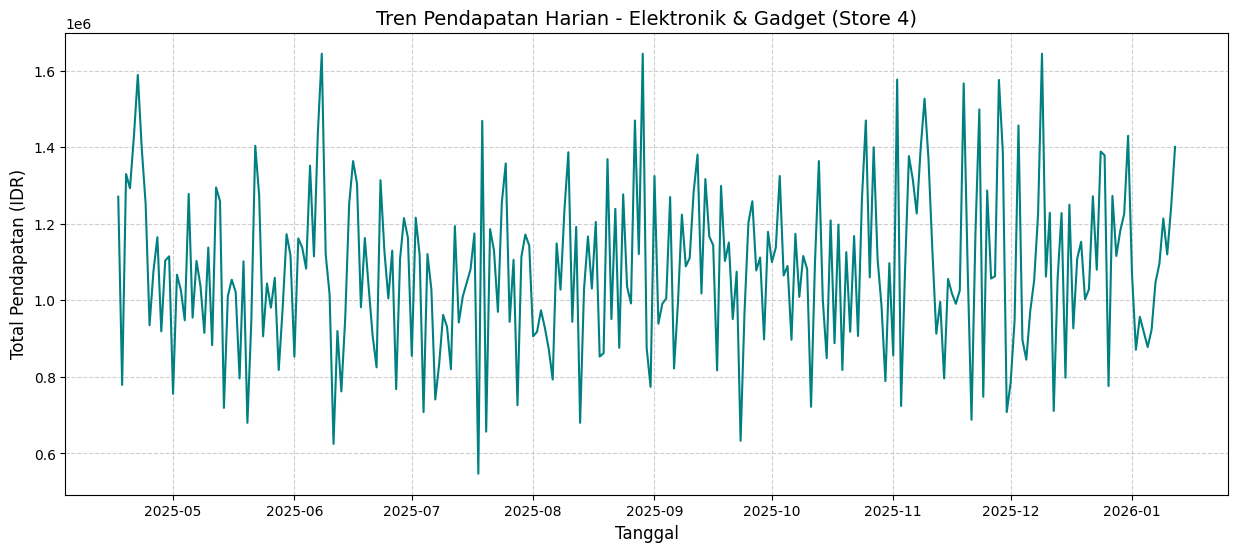

In [121]:
# 1. Tren Pendapatan Harian
plt.figure(figsize=(15, 6))
plt.plot(time_series_electronic.index, time_series_electronic['revenue_clean'], color='teal', linewidth=1.5)
plt.title('Tren Pendapatan Harian - Elektronik & Gadget (Store 4)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

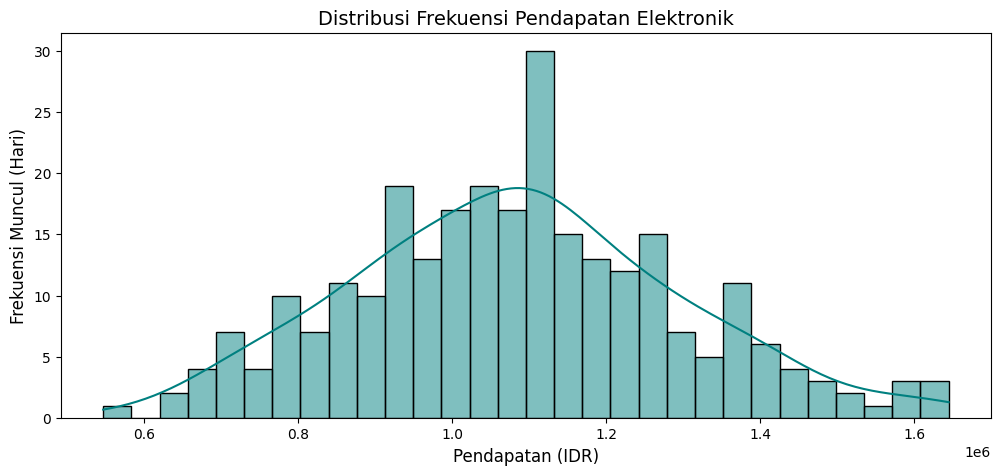

In [122]:
# 2. Distribusi Pendapatan
plt.figure(figsize=(12, 5))
sns.histplot(time_series_electronic['revenue_clean'], kde=True, color='teal', bins=30)
plt.title('Distribusi Frekuensi Pendapatan Elektronik', fontsize=14)
plt.xlabel('Pendapatan (IDR)', fontsize=12)
plt.ylabel('Frekuensi Muncul (Hari)', fontsize=12)
plt.show()

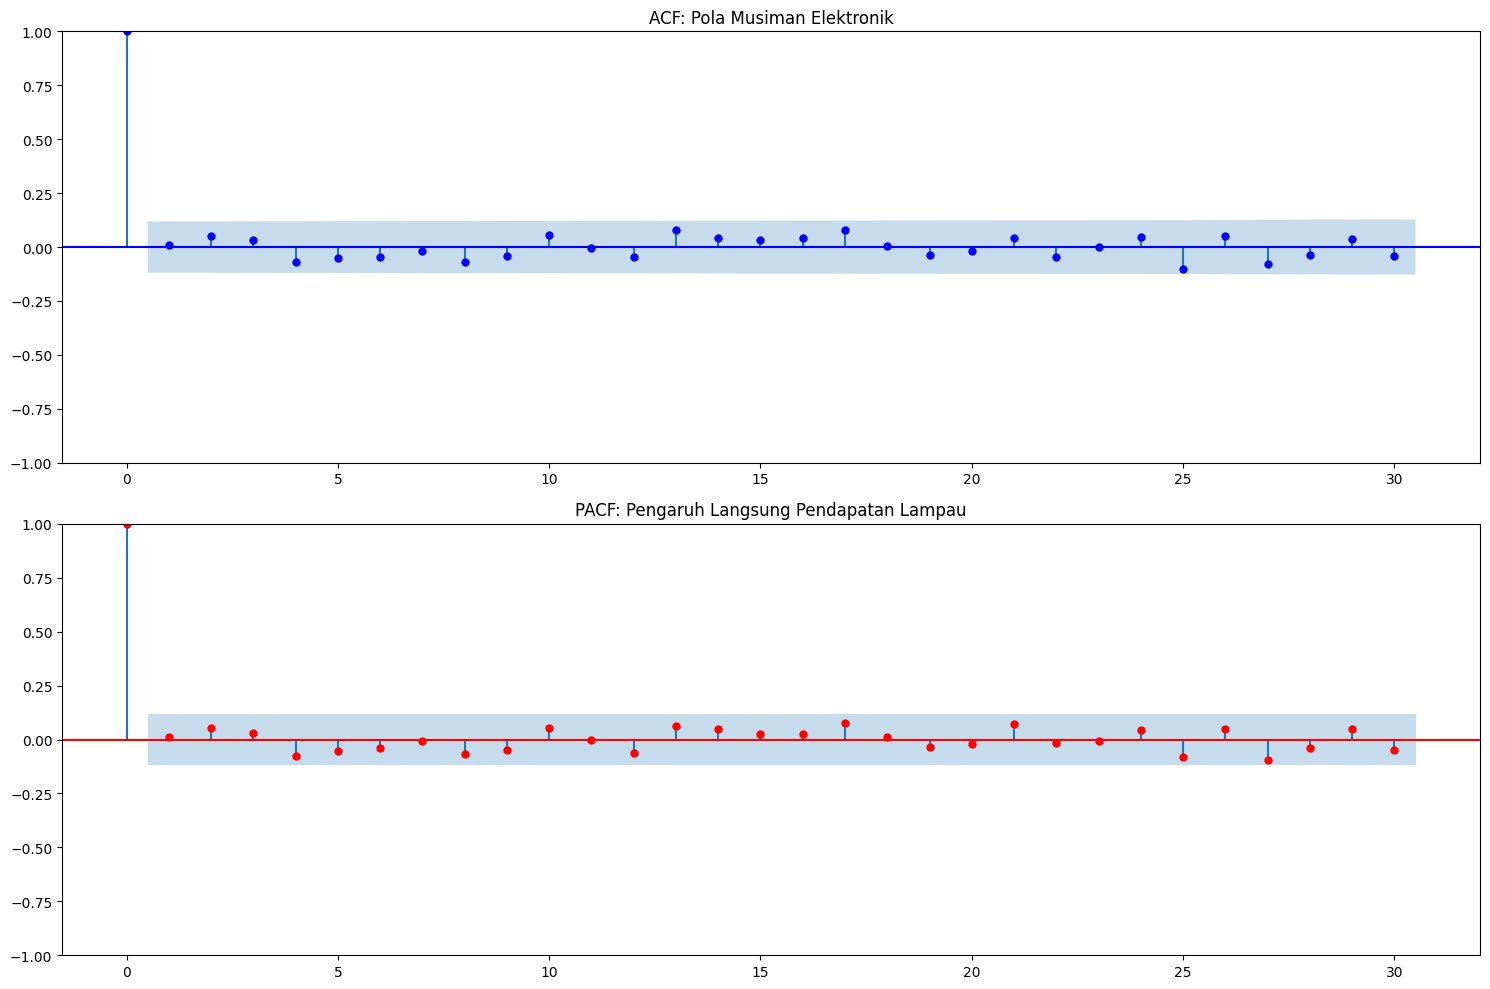

In [123]:
# 3. ACF & PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(time_series_electronic['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('ACF: Pola Musiman Elektronik', fontsize=12)
plot_pacf(time_series_electronic['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('PACF: Pengaruh Langsung Pendapatan Lampau', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-577808326.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='revenue_clean', data=time_series_electronic, order=order, palette='viridis')


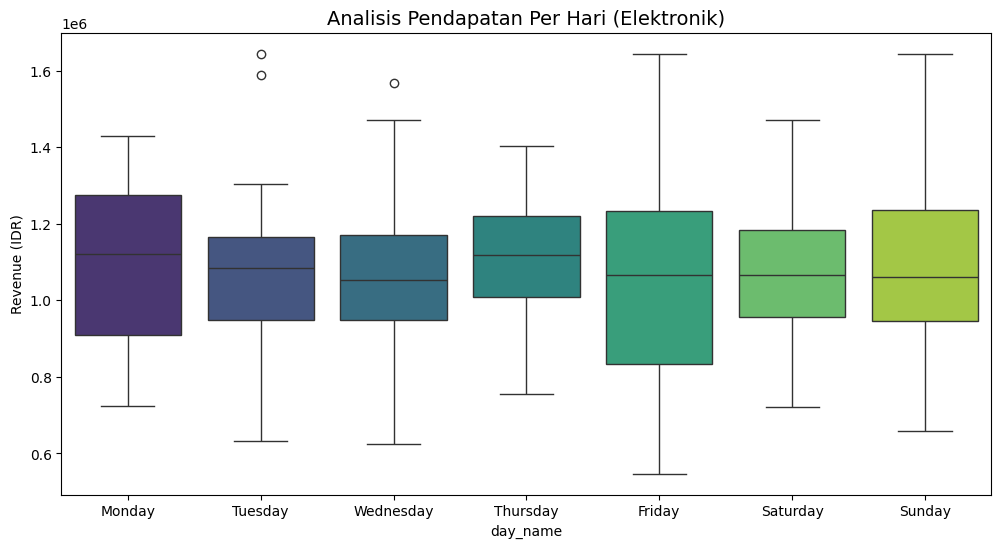

In [124]:
# 4. Boxplot Hari dalam Seminggu
time_series_electronic['day_name'] = time_series_electronic.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_name', y='revenue_clean', data=time_series_electronic, order=order, palette='viridis')
plt.title('Analisis Pendapatan Per Hari (Elektronik)', fontsize=14)
plt.ylabel('Revenue (IDR)')
plt.show()

In [125]:
# 5. Ringkasan Statistik
stats = time_series_electronic['revenue_clean'].describe()
print("="*45)
print("   RINGKASAN STATISTIK PENDAPATAN ELEKTRONIK")
print("="*45)
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Maksimum            : Rp {stats['max']:,.2f}")
print("="*45)

   RINGKASAN STATISTIK PENDAPATAN ELEKTRONIK
Rata-rata Harian    : Rp 1,082,249.08
Standar Deviasi     : Rp 211,808.07
Median (P50)        : Rp 1,081,000.00
Maksimum            : Rp 1,644,500.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [126]:
# 1. Feature Engineering
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_electronic['is_holiday'] = time_series_electronic.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)
time_series_electronic['is_payday'] = time_series_electronic.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)
time_series_electronic['is_weekend'] = time_series_electronic.index.weekday.map(lambda x: 1 if x >= 5 else 0)

In [127]:
# Fitur Lag 1-7
for i in range(1, 8):
    time_series_electronic[f'lag_{i}'] = time_series_electronic['revenue_clean'].shift(i)

In [128]:
# Fitur Tren (Rolling Average 7 hari)
time_series_electronic['rolling_avg_7d'] = time_series_electronic['revenue_clean'].rolling(window=7).mean()

In [129]:
# Update Feature Engineering (Menambah Day of Month)
time_series_electronic['day_of_month'] = time_series_electronic.index.day

In [130]:
# Hapus baris yang kosong akibat proses Lag
time_series_electronic.dropna(inplace=True)

## Scaling

In [131]:
# 2. Definisikan X dan y
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_raw = time_series_electronic[features]
y_raw = time_series_electronic['revenue_clean']

In [132]:
# 3. Scaling (Mengubah angka jutaan ke skala 0-1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [133]:
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

In [134]:
# 4. Reshaping ke format 3D untuk LSTM [Samples, Time Steps, Features]
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_final = y_scaled

## Splitting Data (Train & Test)

In [135]:
# 5. Split Data (80% Training, 20% Testing)
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Preprocessing Selesai! Data siap dilatih dengan {X_train.shape[2]} fitur.")

Preprocessing Selesai! Data siap dilatih dengan 12 fitur.


# Modeling

In [136]:
def model_builder(hp):
    model = Sequential()

    # CNN Layer
    model.add(Conv1D(
        filters=hp.Int("conv_filters", 32, 128, 16),
        kernel_size=1, activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=1))

    # Bi-LSTM Layer
    model.add(Bidirectional(LSTM(units=hp.Int("bilstm_units", 64, 256, 32), return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.4, 0.1)))

    # LSTM 2
    model.add(LSTM(units=hp.Int("lstm_units", 32, 128, 32), return_sequences=False))

    model.add(Dense(hp.Int("dense_units", 32, 128, 32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Reset Tuner Khusus
tuner_path = 'tuner_dir/electronic_tuning'
if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)

tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    directory='tuner_dir',
    project_name='electronic_tuning',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Memulai Hyperparameter Tuning untuk Elektronik...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Ambil Model Terbaik
best_model = tuner.get_best_models(num_models=1)[0]
print("\nTuning Selesai. Arsitektur model terbaik dipilih.")
best_model.summary()

Trial 10 Complete [00h 00m 19s]
val_loss: 0.029746634885668755

Best val_loss So Far: 0.019824858754873276
Total elapsed time: 00h 03m 38s

Tuning Selesai. Arsitektur model terbaik dipilih.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 112)         │         1,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       246,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,201 (1.50 MB)

 Trainable params: 393,201 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [137]:
# 1. Pelatihan Akhir Model Terbaik
print("Melatih model akhir...")
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Melatih model akhir...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0157 - mae: 0.0969 - val_loss: 0.0242 - val_mae: 0.1213
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091 - mae: 0.0769 - val_loss: 0.0206 - val_mae: 0.1082
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0071 - mae: 0.0664 - val_loss: 0.0179 - val_mae: 0.1029
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - mae: 0.0628 - val_loss: 0.0200 - val_mae: 0.1140
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074 - mae: 0.0668 - val_loss: 0.0168 - val_mae: 0.1032
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - mae: 0.0615 - val_loss: 0.0183 - val_mae: 0.1064
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063 - mae: 0.0610 - val_loss: 0.0153 - val_mae: 0.0980
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0058 - mae: 0.0628 - val_loss: 0.0168 - val_mae: 0.1036
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━

In [138]:
# 2. Prediksi & Kembalikan Skala (Inverse Transform)
y_pred_scaled = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step


In [139]:
# 3. Inverse Scale (Kembalikan ke nilai Rupiah asli)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

In [140]:
# 4. Hitung Metrik Utama
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100
r2 = r2_score(y_actual, y_pred)

In [141]:
print("="*50)
print("     HASIL EVALUASI MODEL ELEKTRONIK (STORE 4)")
print("="*50)
print(f"1. Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"2. MAPE (Tingkat Error)       : {mape:.2f}%")
print(f"3. R2-Score (Akurasi Model)   : {r2:.4f}")
print("="*50)

     HASIL EVALUASI MODEL ELEKTRONIK (STORE 4)
1. Mean Absolute Error (MAE)  : Rp 65,778.96
2. MAPE (Tingkat Error)       : 6.32%
3. R2-Score (Akurasi Model)   : 0.8470


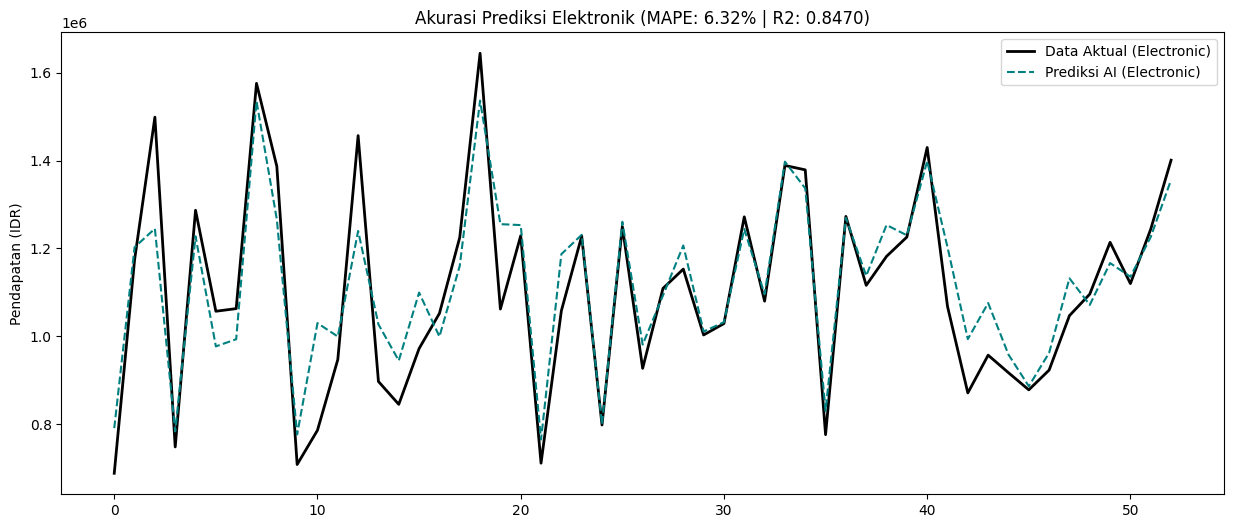

In [142]:
# 4. Visualisasi 1: Prediksi vs Aktual
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual (Electronic)', color='black', linewidth=2)
plt.plot(y_pred, label='Prediksi AI (Electronic)', color='teal', linestyle='--')
plt.title(f'Akurasi Prediksi Elektronik (MAPE: {mape:.2f}% | R2: {r2:.4f})')
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.show()

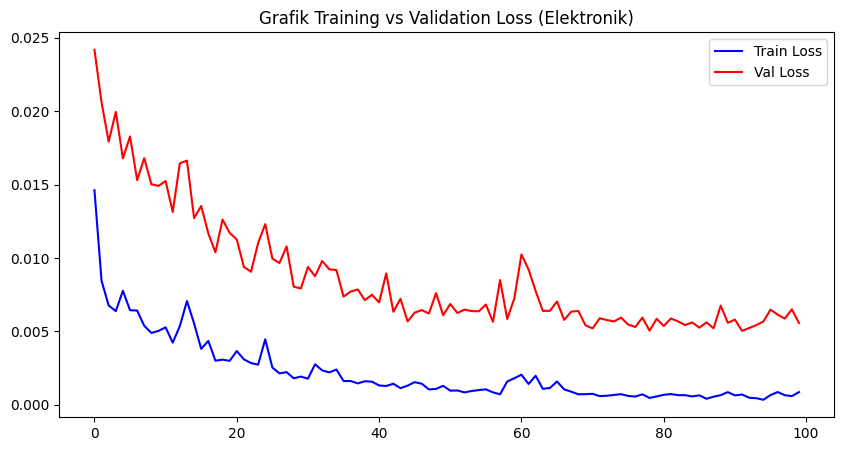

In [143]:
# 5. Visualisasi 2: Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Grafik Training vs Validation Loss (Elektronik)')
plt.legend()
plt.show()

# Save Model

In [144]:
# Simpan Model & Scaler
model_path = '/content/drive/MyDrive/Magang Prima PTKI/models/elektronik/model_electronic_store_4.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
best_model.save(model_path)
joblib.dump(scaler_X, '/content/drive/MyDrive/Magang Prima PTKI/models/elektronik/scaler_X_electronic.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/Magang Prima PTKI/models/elektronik/scaler_y_electronic.pkl')

['/content/drive/MyDrive/Magang Prima PTKI/models/elektronik/scaler_y_electronic.pkl']

# Kode Inference Dengan Analisis Bisnis

In [145]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/elektronik/model_electronic_store_4.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/elektronik/scaler_X_electronic.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/elektronik/scaler_y_electronic.pkl')

In [146]:
def get_forecast_7_days_stabilized_electronic(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (Stabilizer)
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL ELECTRONIC TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Mencegah angka tidak masuk akal
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk iterasi berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        # Status berdasarkan statistik deskriptif data electronic
        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [147]:
# Jalankan Proyeksi Baru untuk Electronic
forecast_results_electronic = get_forecast_7_days_stabilized_electronic(best_model, time_series_electronic, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL ELECTRONIC TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 1,300,999 | RAMAI
Wednesday, 14 Jan: Rp 1,249,244 | RAMAI


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Thursday, 15 Jan: Rp 1,226,459 | RAMAI
Friday, 16 Jan: Rp 1,303,875 | RAMAI
Saturday, 17 Jan: Rp 1,222,245 | RAMAI


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Sunday, 18 Jan: Rp 1,177,198 | NORMAL
Monday, 19 Jan: Rp 1,164,026 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


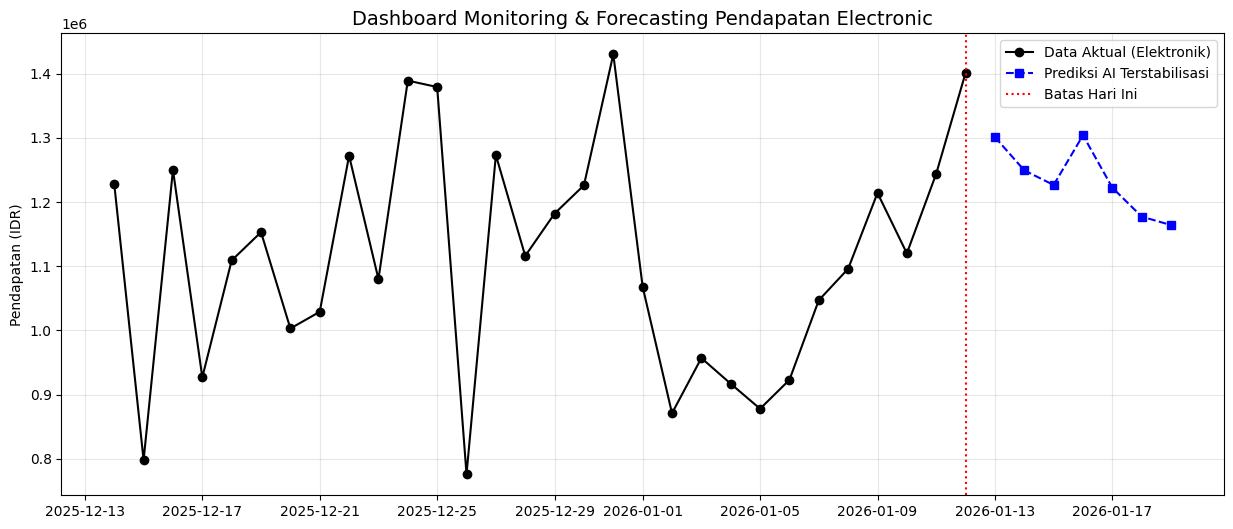

In [148]:
# Visualisasi
plt.figure(figsize=(15, 6))
hist_data_elec = time_series_electronic.tail(30)

plt.plot(hist_data_elec.index, hist_data_elec['revenue_clean'],
         label='Data Aktual (Elektronik)', color='black', marker='o')

plt.plot(forecast_results_electronic.index, forecast_results_electronic['pred_revenue'],
         label='Prediksi AI Terstabilisasi', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data_elec.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Monitoring & Forecasting Pendapatan Electronic', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()